## Covid-19's Impact on the NYC Rental Market
##### Anthony Spinelli
##### updated: 10/04/2022

### General Overview
##### Since April of 2021 rental and covid-19 data has been web scraped from renthop.com and NYC Open Data using python's beautiful soup package every week. This was done in order to estimate the causal impact covid-19 has had on the rental market. Along with the rental and covid data, neighborhood statistics, crime data, and an assortment of other variables have been paired to each observation.

##### The dataset as of 10/04/2022 contains 51 weeks, 824798 rows, and 98 columns totaling 663 MB worth. Each row contains an individual apartment along with a host of describing characteristics ie. rent, latitude and longitude, bed, bath, neighborhood, laundry, ect. The covid-19 data that is joined contains positivity rates, vaccine rates, testing rates and more, all at the neighborhood level. For a great visualization of this data please see https://www1.nyc.gov/site/doh/covid/covid-19-data.page#maps. The data is joined on modified zip code tabulation areas (modzcta). These are geospatial mappings of zip codes around the city to make covid-19 easier to track within each area. The modzcta's are how all variables are joined.

##### When modeling the impact covid has had, we control for other neighborhood variables to hold all else constant. The neighborhood data (at modzcta level) was obtained primarily through the Census ACS-5 dataset which includes data on education, demographics, wealth, and others. Crime data from the NY Open data was also included for each modzcta.

##### This notebook will describe the data in detail. The full dataset, web scraper, and R file which produces the causal estimations will become public once the paper has been published.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# Importing the data for visuals and descriptions
full_data = 'data.csv'
df = pd.read_csv(full_data)
print('')
print(f'Data Size:            {str(round(os.stat(full_data).st_size / (1024 * 1024),2))} MB')
print(f'Weeks Scraped:        {str(len(df.date.value_counts()))}')
print(f'% of a Year Scraped:  {str(round((len(df.date.value_counts())/52)*100,2))}')
print('')
print(f'Starting Week:        {str(list(df.date.drop_duplicates().reset_index(drop=True))[0])}')
print(f'Ending Week:          {str(list(df.date.drop_duplicates().reset_index(drop=True))[-1])}')
print(f'Rows:                 {str(len(df))}')
print(f'Columns:              {str(len(df.columns))}')

#COMBO GRAPH
def combo_graph(given_data,y1,y2):
    graph1 = given_data[[y1,y2,'date']].groupby('date').mean().reset_index().sort_values('date').reset_index(drop=True)
    graph1.date = graph1.date.astype('str').str.replace(' 00:00:00','')
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax1.set_title(str(y1+'      :      '+y2), fontsize=16)
    ax1.set_xlabel('Date', fontsize=16)
    ax1.set_ylabel(y1, fontsize=16, color = 'blue')
    ax1 = sns.lineplot(x ='date' ,y = y1,data = graph1, marker='o', color = 'blue', sort = False)
    ax1.tick_params(axis='x', labelrotation = 45)
    ax2 = ax1.twinx()
    ax2.set_ylabel(y2, fontsize=16, color = 'red')
    ax2 = sns.lineplot(x= 'date', y=y2, data = graph1, marker = 'o', color = 'red', sort=False)
    ax2.tick_params(axis='x', labelrotation = 45)
    plt.show()

/var/folders/t7/c3ghs_pn6rx_4b94lrp0rt3w0000gn/T/ipykernel_22647/3829789706.py:10: DtypeWarning: Columns (7,80,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_data)



Data Size:            1211.87 MB
Weeks Scraped:        80
% of a Year Scraped:  153.85

Starting Week:        2021-04-08
Ending Week:          2022-10-27
Rows:                 1287870
Columns:              97


In [2]:
df.columns

Index(['rent', 'link', 'lat', 'lon', 'borough', 'neighborhood', 'apt_type',
       'flex', 'bath', 'no_fee', 'sqft', 'subway', 'school_dist', 'gym',
       'dishwasher', 'laundry', 'uni_distance', 'modzcta', 'modzcta_name',
       'hospitalization_count_28day', 'hospitalization_rate_28day',
       'death_count_28day', 'death_rate_28day', 'daterange',
       'percentpositivity_7day', 'people_tested', 'people_positive',
       'median_daily_test_rate', 'daterange2', 'COVID_CONFIRMED_CASE_COUNT',
       'COVID_PROBABLE_CASE_COUNT', 'COVID_CASE_COUNT',
       'COVID_CONFIRMED_CASE_RATE', 'COVID_CASE_RATE', 'POP_DENOMINATOR',
       'COVID_CONFIRMED_DEATH_COUNT', 'COVID_PROBABLE_DEATH_COUNT',
       'COVID_DEATH_COUNT', 'COVID_CONFIRMED_DEATH_RATE', 'COVID_DEATH_RATE',
       'PERCENT_POSITIVE', 'TOTAL_COVID_TESTS', 'COUNT_PARTIALLY_CUMULATIVE',
       'COUNT_FULLY_CUMULATIVE', 'COUNT_1PLUS_CUMULATIVE', 'PERC_PARTIALLY',
       'PERC_FULLY', 'PERC_1PLUS', 'median_income', 'gini', 'capita_in

### Variable Descriptions:

#### Individual apartment level variables ~
- rent : the rental price of the listing
- link : the actualing link to the listing at renthop.com
- lat : the latitude of the listing
- lon : the longitude of the listing
- borough : the associated borough of the rental (determined by renthop.com)
- neighborhood : the associated neighborhood of the rental (determined by renthop.com)
- apt_type : the apartment type (1 = studio, 2 = 1 bed, 3 = 2 bed, ect...)
- bath : how many baths in the rental (1 = 1 bath, 2 = 2 bath, ect...)
- no_fee : binary indicator, 1 if their is no fee, 0 if their is a fee
- sqft : the square footage of the rental
- subway : the distance from the nearest subway in miles
- school_dist : distance to the nearest elementary school in miles
- gym : binary indicator, 1 if the rental has a gym in the building, 0 if it does not
- dishwasher : binary indicator, 1 if the rental has a dishwasher, 0 if not
- laundry : binary indicator, 1 if the rental has laundry in building or in unit, 0 if not
- flex : 
- date : day the rental data has been scraped
- month : month the rental data has been scraped

#### Covid-19 Variables grouped at the MODZCTA level ~

- treatment : binary indicator for high and low covid by modzcta. 1 if the modzcta is considered high covid, 0 if low covid. This variable frames the moddleing as a random controlled trial in a senario where an RCT is not possible
- modzcta : modified zip code tabulation area, based on the 2010 Census Zip Code Tabulation Area: https://data.cityofnewyork.us/Health/Modified-Zip-Code-Tabulation-Areas-MODZCTA-/pri4-ifjk
- modzcta_name : Name of the modzcta
- hospitalization_count_28day : hospitalization count for the last 28 days
- hospitalization_rate_28day : hospitalization rate for the last 28 days
- death_count_28day : death count for the last 28 days
- death_rate_28day : death rate for the last 28 days
- daterange : daterange for hospitalization_count_28day, hospitalization_rate_28day, death_count_28day, death_rate_28day
- percentpositivity_7day : percentage of people who tested positive for covid-19 in the past 7 days
- people_tested : total count of people tested for covid-19
- people_positive : total count of people who tested positive for covid-19
- median_daily_test_rate : median daily test rate for covid -19
- daterange2 : daterange for percentpositivity_7day, people_tested, people_positive, median_daily_test_rate, 
- COVID_CONFIRMED_CASE_COUNT : confirmed case count of covid-19
- COVID_PROBABLE_CASE_COUNT : probably case count for covid-19
- COVID_CASE_COUNT : total covid case count
- COVID_CONFIRMED_CASE_RATE : confirmed covid case rate
- COVID_CASE_RATE : covid case rate
- POP_DENOMINATOR : population estimation for the modzcta
- COVID_CONFIRMED_DEATH_COUNT : confirmed count of deaths by covid-19
- COVID_PROBABLE_DEATH_COUNT : probable count of deaths by covid-19
- COVID_DEATH_COUNT : total covid death count
- COVID_CONFIRMED_DEATH_RATE : confirmed death rate
- COVID_DEATH_RATE : rate of deaths per population of modzcta
- PERCENT_POSITIVE : percentage of people who test positive for covid-19
- TOTAL_COVID_TESTS : total covid tests administered
- COUNT_PARTIALLY_CUMULATIVE : count of people partially vaccinated
- COUNT_FULLY_CUMULATIVE : count of people fully vaccinated
- COUNT_1PLUS_CUMULATIVE : count of people who have recieved at least 1 dose of the vaccine
- PERC_PARTIALLY : percentage of people partially vaccinated
- PERC_FULLY : percentage of people fully vaccinated
- PERC_1PLUS : percentage of people with at least 1 dose of the vaccine

#### Covid variables on the weekly level ~

- indoor_dining_cap : percentage of indoor dining capacity mandated
- 12am_curfew : binary indicator for when the 12am curfew was in place
- vax_mask : binary indicator for when the mask mandate was in place

#### Crime variables on the MODZCTA level ~

- complaints : count of complaints for the past 3 months
- arrests : count of arrests for the past 3 months
- shoots : count of shootings that occured within each modzcta for that week
- shoots_daily : count of shootings that occured within each modzcta for that week
- arrests_daily : count of arrests that occured within each modzcta for that week

#### neighborhood statistics on the MODZCTA level ~

- median_income : median income of the modzcta
- gini : gini coeficent for the modzcta
- capita_inc : per capita income per modzcta
- male_pop : male population count per modzcta
- female_pop : female population per modzcta
- median_age : median age per modzcta
- total_pop : total population of modzcta
- total_race : count of total race variables per modzcta
- white_alone : count of white race per modzcta
- black_alone : count of black race per modzcta
- indian : count of indian race per modzcta
- asian_alone : count of asian race per modzcta
- hawaiian_pacific_islander : count of hawaiian pacific islander race per modzcta
- highschool : count of highschool students per modzcta
- no_school : count of people with no education per modzcta
- associates : count of people with an associates degree per modzcta
- bachelors : count of people with an bachelors degree per modzcta
- masters : count of people with a masters degree per modzcta
- educ_pop : total count of people for education statistics
- state : census code for NY (36)
- B08124 : count of the "front line workers" population #1 (this variable along with C24070 are two seperately defined counts of estimated frontline workers per modzcta)
- C24070 : count of the "front line workers" population #2
- square_miles : square miles of the modzcta
- density : population density of the modzcta
- frontline_percent_1 : percentage of frontline workers per modzcta #1
- frontline_percent_2 : percentage of frontline workers per modzcta #2
- perc_white : percentage of the populatin that is white
- perc_black : percentage of the populatin that is black
- perc_indian : percentage of the populatin that is indian
- perc_asian : percentage of the populatin that is asian
- perc_pacific : percentage of the populatin that is hawaiian pacific islander
- perc_highschool : percentage of the population with just a highschool degree
- perc_no_school : percentage of the population with no schooling
- perc_associates : percentage of the population with just a associates degree
- perc_bachelors : percentage of the population with just a bachelors degree
- perc_masters : percentage of the population with just a masters degree
- uni_count : count of college universities per modzcta
- subway_count : count of subway lines per modzcta
- res_count : count of resturaunts per modzcta

#### Unemployment Rate on the monthly level ~

- UNRATE : unemployment rate

In [3]:
# Example of one listing in the dataset
df.head()[4:5][['rent', 'link', 'lat', 'lon', 'borough', 'neighborhood', 'apt_type','bath', 'no_fee', 'sqft', 'subway', 'school_dist', 'gym', 'dishwasher','laundry', 'modzcta']]

,rent,link,lat,lon,borough,neighborhood,apt_type,bath,no_fee,sqft,subway,school_dist,gym,dishwasher,laundry,modzcta
4,3438.0,https://www.renthop.com/listings/201-east-12th...,40.7318,-73.9875,Manhattan,EastVillage,3.0,1,0.0,NaN,0.1,0.23,0.0,0.0,0.0,10003.0


### Rental variable descriptions

In [4]:
df[['rent', 'link', 'lat', 'lon', 'borough', 'neighborhood', 'apt_type','bath', 'no_fee', 'sqft', 'subway', 'school_dist', 'gym', 'dishwasher','laundry']].describe()

,rent,lat,lon,apt_type,bath,no_fee,sqft,subway,school_dist,gym,dishwasher,laundry
count,1.287870e+06,1.287870e+06,1.287870e+06,1.287870e+06,1.287870e+06,1.287870e+06,2.624800e+05,1.092485e+06,1.287683e+06,1.287870e+06,1.287870e+06,1.287870e+06
mean,4.173795e+03,4.074030e+01,-7.396705e+01,2.518860e+00,1.256387e+00,6.611747e-01,1.054881e+03,2.124779e-01,3.393184e-01,3.793908e-01,5.160614e-01,6.682786e-01
std,2.060024e+03,4.488528e-02,4.111075e-02,1.094013e+00,4.834870e-01,4.733106e-01,3.445735e+04,1.348163e-01,4.040386e-01,4.852356e-01,4.997422e-01,4.708317e-01
min,6.000000e+02,4.050010e+01,-7.424940e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.700000e+03,4.070970e+01,-7.399110e+01,2.000000e+00,1.000000e+00,0.000000e+00,6.240000e+02,1.200000e-01,1.400000e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.695000e+03,4.074390e+01,-7.397630e+01,2.000000e+00,1.000000e+00,1.000000e+00,8.000000e+02,1.900000e-01,2.500000e-01,0.000000e+00,1.000000e+00,1.000000e+00
75%,5.096000e+03,4.076860e+01,-7.395090e+01,3.000000e+00,1.000000e+00,1.000000e+00,1.094000e+03,2.800000e-01,3.900000e-01,1.000000e+00,1.000000e+00,1.000000e+00
max,1.500000e+04,4.091180e+01,-7.370100e+01,5.000000e+00,3.000000e+00,1.000000e+00,1.500100e+07,1.000000e+00,1.273000e+01,1.000000e+00,1.000000e+00,1.000000e+00


### Covid variable descriptions

In [5]:
df[['modzcta','hospitalization_count_28day','hospitalization_rate_28day', 'death_count_28day', 'death_rate_28day', 'percentpositivity_7day', 'people_tested',
    'people_positive', 'median_daily_test_rate','COVID_CONFIRMED_CASE_COUNT', 'COVID_PROBABLE_CASE_COUNT','COVID_CASE_COUNT', 'COVID_CONFIRMED_CASE_RATE',
    'COVID_CASE_RATE','POP_DENOMINATOR', 'COVID_CONFIRMED_DEATH_COUNT','COVID_PROBABLE_DEATH_COUNT', 'COVID_DEATH_COUNT','COVID_CONFIRMED_DEATH_RATE',
    'COVID_DEATH_RATE', 'PERCENT_POSITIVE','TOTAL_COVID_TESTS', 'COUNT_PARTIALLY_CUMULATIVE','COUNT_FULLY_CUMULATIVE', 'COUNT_1PLUS_CUMULATIVE',
    'PERC_PARTIALLY','PERC_FULLY', 'PERC_1PLUS']].drop_duplicates().reset_index(drop=True).describe()

,modzcta,hospitalization_count_28day,hospitalization_rate_28day,death_count_28day,death_rate_28day,percentpositivity_7day,people_tested,people_positive,median_daily_test_rate,COVID_CONFIRMED_CASE_COUNT,...,COVID_CONFIRMED_DEATH_RATE,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS,COUNT_PARTIALLY_CUMULATIVE,COUNT_FULLY_CUMULATIVE,COUNT_1PLUS_CUMULATIVE,PERC_PARTIALLY,PERC_FULLY,PERC_1PLUS
count,12491.000000,12491.000000,10128.000000,6196.000000,6196.000000,12491.000000,12491.000000,12491.000000,12491.000000,10356.000000,...,10356.000000,12491.000000,12491.000000,12491.000000,11633.000000,11633.000000,11633.000000,11633.000000,11633.000000,11633.000000
mean,10794.135458,21.522937,47.918474,4.744997,8.199806,7.341432,1345.212633,98.173965,464.990161,9592.964658,...,360.517249,394.594385,17.920753,44780.625650,3430.781570,31596.286083,35027.067652,9.342309,0.815151,92.552115
std,581.509417,33.999548,56.130628,7.416613,12.372454,7.194221,1107.661322,209.829404,309.037836,6604.016522,...,162.392289,185.265015,6.533264,24339.323246,2172.855814,16778.725192,18578.554774,6.023863,0.134697,21.597373
min,10001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,35.900000,182.000000,...,0.000000,0.000000,3.030000,2376.000000,135.000000,2380.000000,2577.000000,3.290000,0.324500,39.430000
25%,10069.000000,5.000000,18.400000,0.000000,0.000000,1.820000,564.000000,20.000000,232.800000,4406.500000,...,259.000000,273.440000,13.310000,26501.500000,1823.000000,19256.000000,21477.000000,6.540000,0.745000,81.330000
50%,11109.000000,12.000000,31.500000,0.000000,0.000000,4.640000,1052.000000,44.000000,409.400000,8318.000000,...,365.860000,393.750000,17.470000,41052.000000,3032.000000,28957.000000,32087.000000,8.040000,0.829900,90.990000
75%,11356.000000,24.000000,53.000000,7.000000,13.700000,11.100000,1839.500000,87.000000,600.500000,13153.250000,...,453.000000,497.670000,23.420000,60986.000000,4569.000000,42428.000000,47217.000000,10.240000,0.914400,100.560000
max,11694.000000,446.000000,587.300000,80.000000,102.300000,44.800000,12370.000000,2706.000000,4008.500000,31495.000000,...,1190.270000,1389.920000,35.730000,125758.000000,13989.000000,88808.000000,100890.000000,70.370000,0.999900,237.280000


### Graph of average rental price and vaccine rates over time

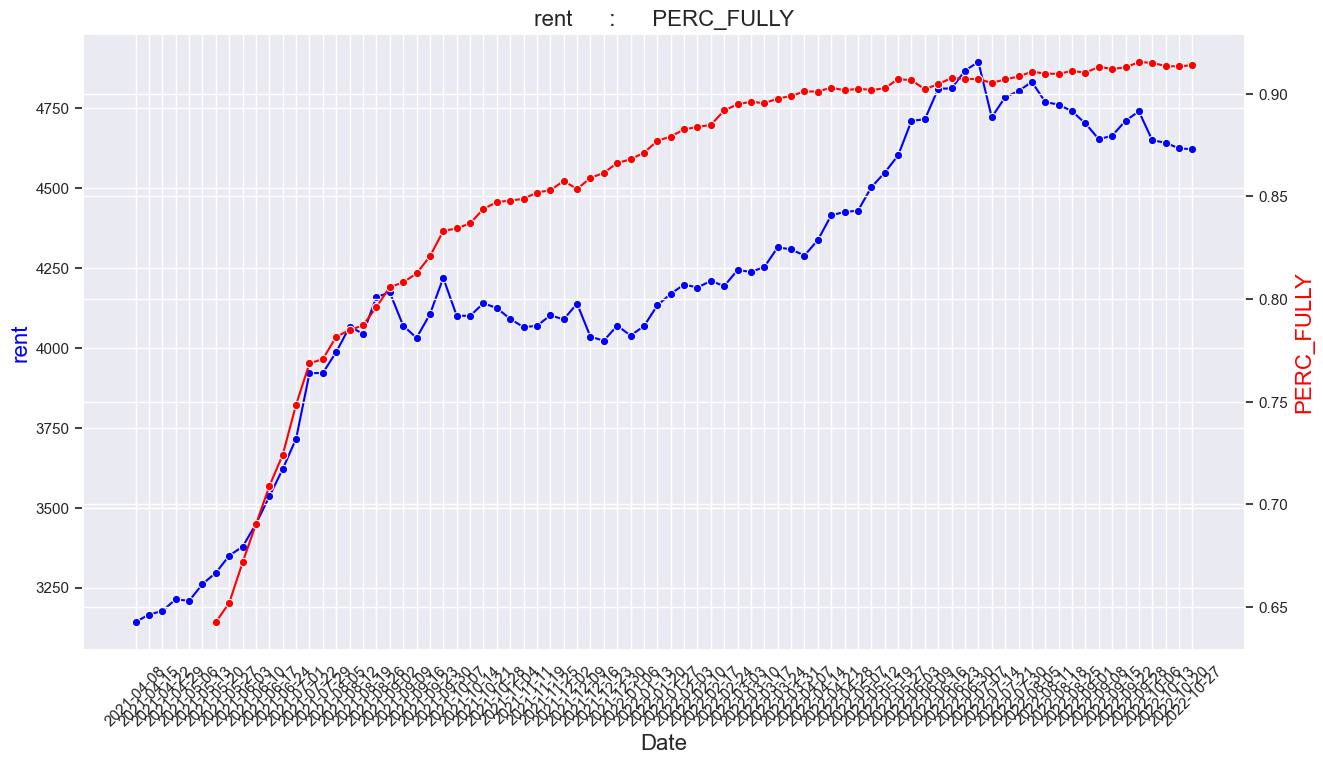

In [11]:
combo_graph(df,'rent','PERC_FULLY')

### Graph of average rental price and weekly percent positivity over time

* Note the "Omnicron spike" from December of 2021 to February of 2022


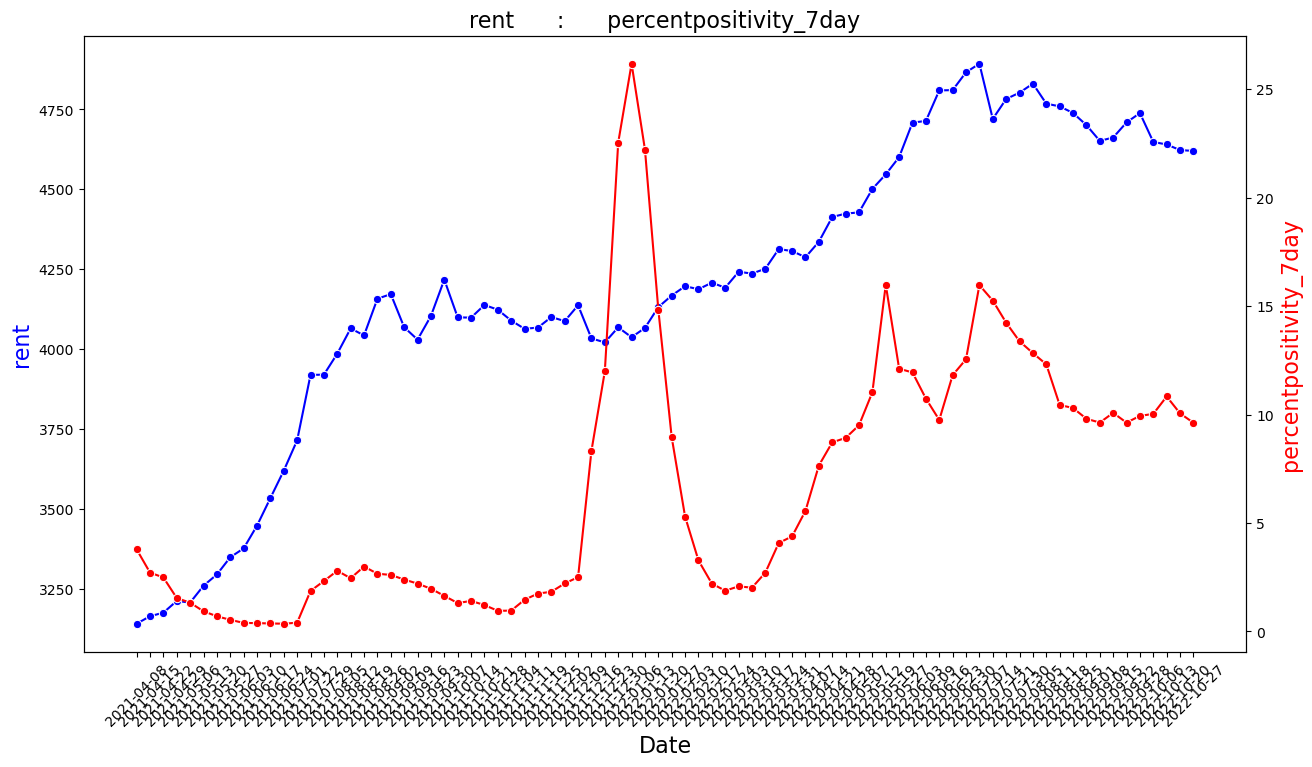

In [7]:
print('* Note the "Omnicron spike" from December of 2021 to February of 2022')
combo_graph(df,'rent','percentpositivity_7day')

### Distrobution of our rent price variable

Text(0.5, 1.0, 'Distrobution of Rental Prices in NYC (All 5 Boroughs)')

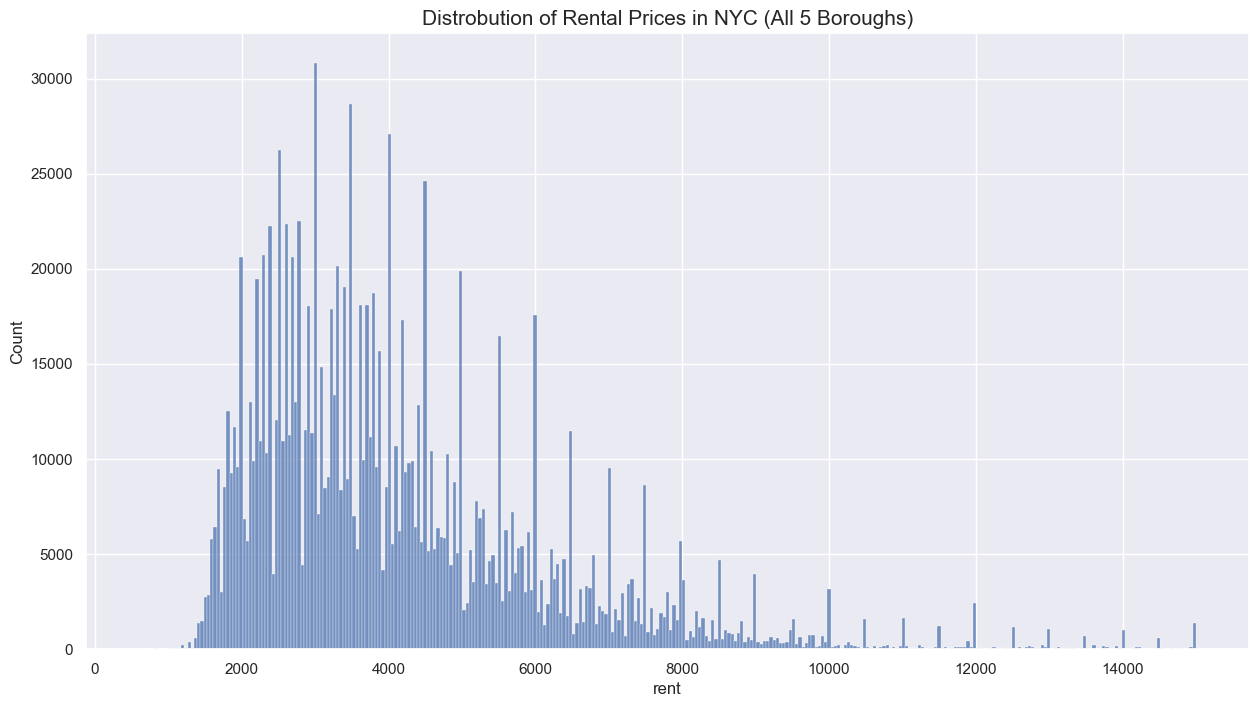

In [8]:
# Distrobutions
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(df.rent)
plt.title('Distrobution of Rental Prices in NYC (All 5 Boroughs)',size = 15)

### Standardized distrobution of our rental price variable

Text(0.5, 1.0, 'Standardized Distrobution of Rental Prices in NYC (All 5 Boroughs)')

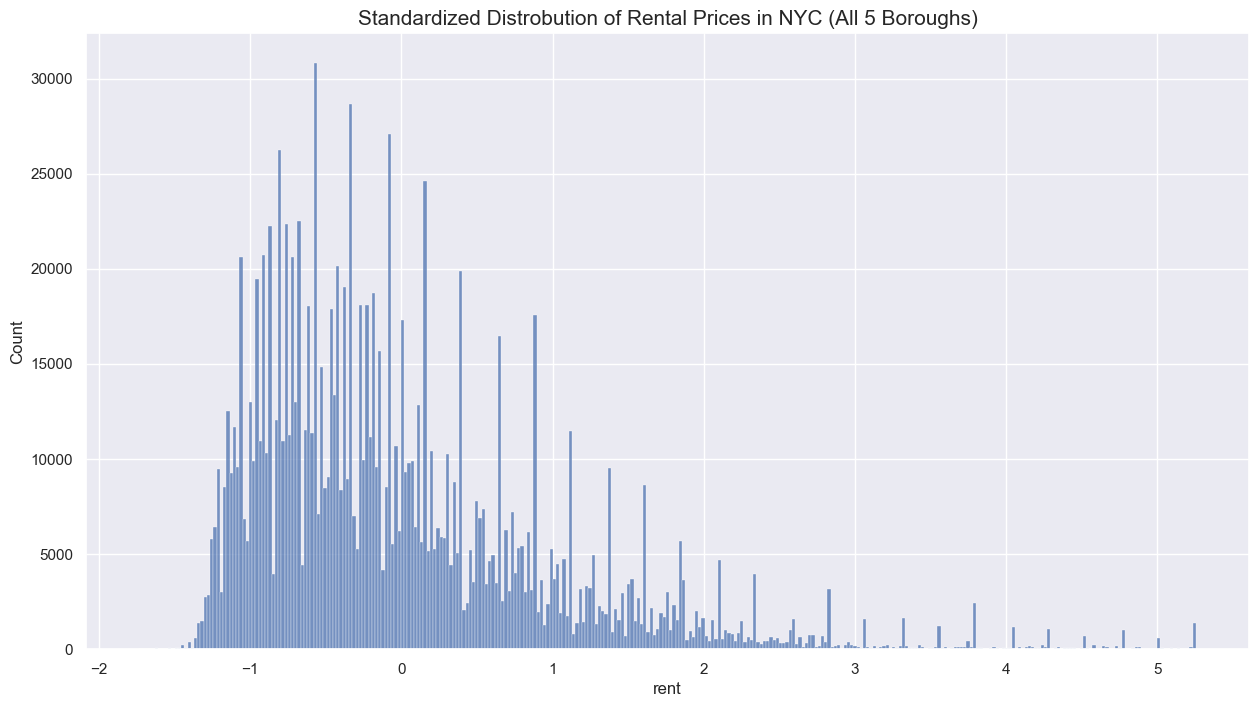

In [9]:
sns.histplot(((df.rent - df.rent.mean()) / (df.rent).std()))
plt.title('Standardized Distrobution of Rental Prices in NYC (All 5 Boroughs)',size = 15)

### Bar plot of the median income of our nieghborhoods (modzcta)

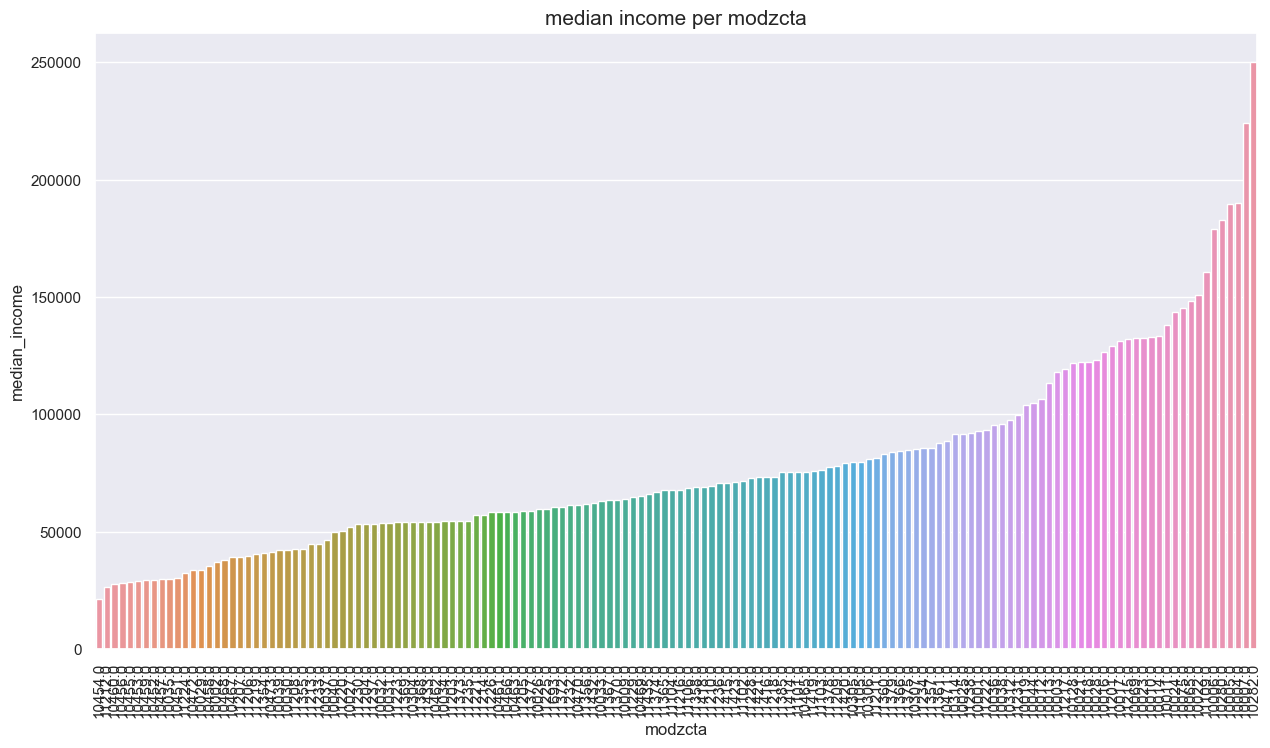

In [10]:
# Bar plot of meidan income per neighborhood
median_income_graph = df[df.date=='2021-04-08'][['median_income','modzcta']].drop_duplicates().reset_index(drop=True)
sns.barplot(x="modzcta", y="median_income", data=median_income_graph, order=median_income_graph.sort_values('median_income').modzcta)
plt.title('median income per modzcta',size = 15)
plt.tick_params(axis='x', labelrotation = 90)